# Common imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import copy
from scipy import ndimage
from matplotlib.patches import Circle
import math
from skimage.transform import resize
import time


# Provided functions
### Image loading and saving

In [2]:
def LoadInputImage(subject_name):
    
    ''' Read and convert the image to grayscale'''
    fname = subject_name+".jpg"
    im = Image.open(fname, 'r')
    img = im.convert('L')
    input_im =  (np.asarray(img)/255)
    print(input_im.shape, np.amin(input_im), np.amax(input_im))
    return input_im.astype(float)
    

In [3]:
def plot_image(subject_image, title):
    fig = plt.figure()
    plt.imshow(subject_image*255, cmap='gray')
    #plt.axis('off')
    plt.title(title)

## Scale-space generation filters

In [4]:
def upsize_filter(input_image, initial_sigma = 2, levels = 15, scale_factor = 1.189):
    ''' LoG filter and return squared scale normalized values in scale-space 3D array'''
    scale_space = np.empty((input_image.shape[0],input_image.shape[1],levels))
    sigma = initial_sigma
    for i in range(levels):
        scale_space[:,:,i] =  (ndimage.filters.gaussian_laplace(input_image, sigma = sigma)  * (sigma ** 2)) ** 2
        #plot_one_image(scale_space[:,:,i], subject_name + "_" + str(sigma))
        sigma = sigma * scale_factor
    return scale_space



In [5]:
def downsample_image(input_image, sigma = 2 , levels = 15, scale_factor = 1.189):
    ''' Downsample the image and upsample the result.
        no scale normalization needed, resize and square the response'''
    scale_space = np.empty((input_image.shape[0],input_image.shape[1],levels))
    
    for i in range(levels):
        
        resized_x = round(input_image.shape[0] / (scale_factor ** i))
        resized_y = round(input_image.shape[1] / (scale_factor ** i))
        resized_image = resize(input_image, (resized_x,resized_y ), anti_aliasing=True,mode='reflect')
        log_image = ndimage.filters.gaussian_laplace(resized_image, sigma = sigma) 
        #print(log_image.shape, np.amin(log_image), np.amax(log_image))
        scale_space[:,:,i] = resize(log_image, (input_image.shape[0],input_image.shape[1] ),anti_aliasing=True,mode='reflect') ** 2
        
    return scale_space    
        
        
        
    
    

In [6]:
def non_maximum_suppression(scale_space, kernel_2d_size = 3):
    
    ''' 3D non-maximum suppression in 2 stages'''
    image_max_filter = np.empty((input_image.shape[0],input_image.shape[1],levels))


    #2D suppression
    for i in range(levels):
        image_max_filter[:,:,i] = ndimage.maximum_filter(scale_space[:,:,i], size = (kernel_2d_size,kernel_2d_size))
        
    #3D folow-up  
   
    for i in range(1, levels - 1):
        image_max_filter[:,:,i] = np.maximum(image_max_filter[:,:,i-1], image_max_filter[:,:,i])
        image_max_filter[:,:,i] = np.maximum(image_max_filter[:,:,i+1], image_max_filter[:,:,i])

    #Special case for first and  last levels
    image_max_filter[:,:,0] = np.maximum(image_max_filter[:,:,0],image_max_filter[:,:,1])
    image_max_filter[:,:,levels-1] = np.maximum(image_max_filter[:,:,levels-1],image_max_filter[:,:,levels-2])
    
    #Create image mask and return NMS image
    image_mask = (scale_space == image_max_filter)
    masked_output_image = np.multiply(image_max_filter, image_mask)
    
    return masked_output_image



In [7]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [8]:
def generate_circles(masked_output_image, sigma, scale_factor, threshold = 0.009):
    ''' Function to generate circle centres and radii from NMS image using threshold'''

    
    cx_list = []
    cy_list = []
    rad_list = []
    #print("Number of circles, sigma, radius")
    for i in range(levels):
        cx, cy = np.where(masked_output_image[:,:,i] > threshold)
        rad = sigma * math.sqrt(2) 
        cx_list.extend(cx)
        cy_list.extend(cy)
        rad_list.extend([rad]*len(cx))
        #print(len(cx), sigma, rad)
        sigma = sigma * scale_factor
    return cx_list, cy_list, rad_list

## Main function

(356, 493) 0.0 1.0


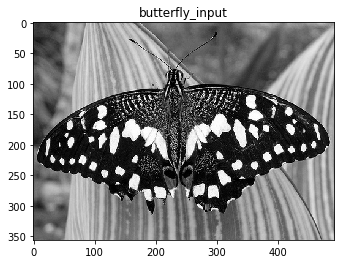

In [9]:
#(Image_name, initial_sigma, levels, scale, kernel_size, threshold_upsize, threshold_downsize)
#Butterly image, 2, 15, 1.189, 5,0.013, 0.001 
#einstein, 2,15,1.273,7,0.003,0.0002
#fishes, 2,13,1.257,5,0.005,0.0004
#sunflower, 2, 15, 1.189, 0.01, 0.007
#small_ball 2,15,1.21,5,0.005,0.0008
#tulips 2,15,1.189,5,0.005,0.0003
# horses 2,15,1.189,7,0.001, 0.00007
# zebra 2,15,1.189,5,0.02, 0.0015

subject_name = 'butterfly'
initial_sigma = 2
levels = 15
scale_factor = 1.189
kernel_2d_size = 5  # Window size for 2D non-maximum suppression
input_image = LoadInputImage(subject_name)
plot_image(input_image, subject_name+"_input")
threshold_upfilter = 0.013
threshold_downimage = 0.001

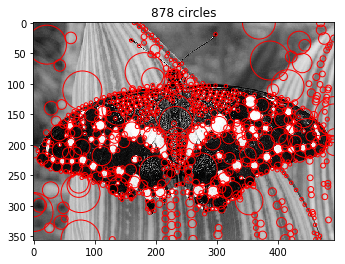

 Upsize filter execution time  0.3150938


In [10]:
#Method 1
#Average 10 times to get runtime
total_time = 0
#Change the range to 10 for time calculation part only
for i in range(1):
    start = time.process_time()
    scale_space = upsize_filter(input_image, initial_sigma, levels, scale_factor)
    masked_image = non_maximum_suppression(scale_space, kernel_2d_size)
    cx_list, cy_list, rad_list = generate_circles(masked_image, initial_sigma,scale_factor, threshold_upfilter)
    show_all_circles(input_image, cy_list, cx_list, rad_list, color='r')
    total_time = total_time + time.process_time() - start
    
print(" Upsize filter execution time ", total_time/10)

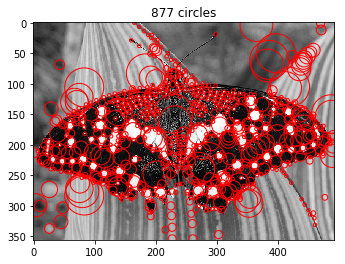

 Average Downsample image execution time  0.21448099999999987


In [11]:
##### Method2 : Downsample image
#Average run-time 10 times to get runtime
total_time = 0
#Change the range to 10 for time calculation part only
for i in range(1):
    start = time.process_time()
    scale_space = downsample_image(input_image, initial_sigma, levels, scale_factor)
    masked_image = non_maximum_suppression(scale_space, kernel_2d_size)
    cx_list, cy_list, rad_list = generate_circles(masked_image, initial_sigma,scale_factor, threshold_downimage)
    show_all_circles(input_image, cy_list, cx_list, rad_list, color='r')
    total_time = total_time + time.process_time() - start
print(" Average Downsample image execution time ", total_time/10)